# WORKFLOW 1

#### Define vars

In [1]:
# DEFINE LOADTESTING VARIABLES

# Define variables for TEST-BM
test_bm_vus = 10
test_bm_duration = "60s"

# Define threshold enum
from enum import Enum
class ThresholdValue(Enum):
    AVG = 0
    MED = 1
    P60 = 2
    P65 = 2

# Define threshold value
bm_threshold_value = ThresholdValue.P60
# In case of AVG, define percent of improvement for function-optimized
bm_threshold_improvement = 5

# Define variables for FUNCTION EXECUTION
vus = 10
duration = 30
duration_with_format = str(duration) + "m" # time formats: s, m, h

# Define how many minutes back we have to fetch
fetch_minutes_back = int(duration + (0.25 * duration))

In [2]:
# IMPORT PYTHON MODULES

import os
import sys
from datetime import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# import fetch functions
sys.path.append(os.path.abspath("logs_fetch"))
from logs_fetch.logs_fetch import PROJECT_ID
from logs_fetch.logs_fetch import CloudFunction
from logs_fetch.logs_fetch import fetch_logs_and_save

# import analytics functions
from logs_metrics.calc_median_function_execution import return_median_function_execution

from logs_metrics.calc_median_download import return_median_download

from logs_metrics.calc_median_lr_duration import  return_median_lr_duration

In [3]:
# GLOBAL PYTHON VARIABLES

today_date = datetime.now().strftime("%Y-%m-%d")

window_size = 50

In [4]:
# SETUP FOLDER FOR LOGS AND PLOTS

base_folder_path = os.path.join(os.getcwd(), "logs_analysis", today_date)

# Create the directory if it doesn't exist
os.makedirs(base_folder_path, exist_ok=True)
    
# Check the number of existing subfolders for today's date
existing_folders = [f.name for f in os.scandir(base_folder_path) if f.is_dir()]
execution_count = len(existing_folders) + 1  # Increment folder name based on the existing number of folders
    
# Create a unique subfolder for this execution
curr_exec_folder_path = os.path.join(base_folder_path, f"execution_{execution_count}")
os.makedirs(curr_exec_folder_path, exist_ok=True)

#### Execute functions and fetch data

In [5]:
# CREATE AND EXECUTE TEST BENCHMARK COMMAND
command_test_bm = f"cd ../loadtesting/test-benchmark && k6 run --env VUS={test_bm_vus} --env DURATION={test_bm_duration} script.js --quiet"

# Run the command
get_ipython().system(f"{command_test_bm}")

INFO[0061] HANDLE SUMMARY                                source=console
ERRO[0061] thresholds on metrics 'total_duration' have been crossed 


In [6]:
# CALCULATE THRESHOLD
import json

file_path = "../loadtesting/test-benchmark/summary.json"

# Load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Access the values of 'min' and 'med'
min_value_sec = data['total_duration']['values']['min']
max_value_sec = data['total_duration']['values']['max']

avg_value_sec = data['total_duration']['values']['avg']
med_value_sec = data['total_duration']['values']['med']
p60_value_sec = data['total_duration']['values']['p(60)']
p65_value_sec = data['total_duration']['values']['p(65)']

# Convert seconds to microseconds
min_value_us = int(min_value_sec * 1_000_000)
max_value_us = int(max_value_sec * 1_000_000)

avg_value_us = int(avg_value_sec * 1_000_000)
med_value_us = int(med_value_sec * 1_000_000)
p60_value_us = int(p60_value_sec * 1_000_000)
p65_value_us = int(p65_value_sec * 1_000_000)

# Print the results
print(f"Min: {min_value_us} µs")
print(f"Max: {max_value_us} µs")

print(f"Avg: {avg_value_us} µs")
print(f"Med: {med_value_us} µs")
print(f"p(60): {p60_value_us} µs")
print(f"p(65): {p65_value_us} µs")

match bm_threshold_value:
    case ThresholdValue.AVG:
        percent_improvement = bm_threshold_improvement / 100
        bm_max_duration = str(avg_value_us - int(percent_improvement * avg_value_us))
    case ThresholdValue.MED:
        bm_max_duration = str(med_value_us)
    case ThresholdValue.P60:
        bm_max_duration = str(p60_value_us)
    case ThresholdValue.P65:
        bm_max_duration = str(p65_value_us)

bm_max_duration = str(p60_value_us)
print("\nBM threshold: " + bm_max_duration + " µs")

Min: 29039 µs
Max: 266510 µs
Avg: 121392 µs
Med: 116594 µs
p(60): 144478 µs
p(65): 153806 µs

BM threshold: 144478 µs


In [7]:
# CREATE AND EXECUTE OPTIMIZED AND BASELINE LOADTESTING COMMANDS

# Define max bm duration and add param to url
maxBenchmarkDuration = bm_max_duration + "us" if bm_max_duration else "3850us"
optimized_url = f"https://europe-west3-bsc-thesis-implementation.cloudfunctions.net/optimizedFunction?maxBenchmarkDuration={maxBenchmarkDuration}"

# Construct the individual commands for each `k6` run
command_optimized = f"cd ../loadtesting/test-function-optimized && k6 run --env URL='{optimized_url}' --env VUS={vus} --env DURATION={duration_with_format} script.js --quiet"
command_baseline = f"cd ../loadtesting/test-function-baseline && k6 run --env VUS={vus} --env DURATION={duration_with_format} script.js --quiet"

# Run both commands in the background
get_ipython().system(f"({command_optimized}) & ({command_baseline})")

WARN[0000] Error from API server                         error="listen tcp 127.0.0.1:6565: bind: address already in use"

     ✓ status 200

     checks.........................: 100.00% 4631 out of 4631
     data_received..................: 1.4 MB  801 B/s
     data_sent......................: 357 kB  198 B/s
     http_req_blocked...............: avg=156.71µs min=0s       med=2µs   max=90.78ms p(90)=3µs    p(95)=4µs   
     http_req_connecting............: avg=45.85µs  min=0s       med=0s    max=29.42ms p(90)=0s     p(95)=0s    
     http_req_duration..............: avg=2.89s    min=494.09ms med=2.99s max=8.04s   p(90)=3.96s  p(95)=4.18s 
       { expected_response:true }...: avg=2.89s    min=494.09ms med=2.99s max=8.04s   p(90)=3.96s  p(95)=4.18s 
     http_req_failed................: 0.00%   0 out of 4631
     http_req_receiving.............: avg=750.99µs min=21µs     med=358µs max=24.49ms p(90)=1.7ms  p(95)=2.71ms
     http_req_sending...............: avg=589.33µs min=31µs     med=

In [8]:
# FETCH OPTIMIZED LOGS

fetch_logs_and_save(CloudFunction.OPTIMIZED, PROJECT_ID, fetch_minutes_back, curr_exec_folder_path)

Analyzing logs for Cloud Function: optimizedFunction
Logs saved to /Users/nilsholler/Desktop/bsc-thesis-implementation/jupyter/logs_analysis/2025-02-06/execution_2/2025-02-06-optimizedFunction-logs.csv



In [9]:
# Wait with execution because of request quota

import time
time.sleep(60)

In [10]:
# FETCH BASELINE LOGS

fetch_logs_and_save(CloudFunction.BASELINE, PROJECT_ID, fetch_minutes_back, curr_exec_folder_path)

Analyzing logs for Cloud Function: baselineFunction
Logs saved to /Users/nilsholler/Desktop/bsc-thesis-implementation/jupyter/logs_analysis/2025-02-06/execution_2/2025-02-06-baselineFunction-logs.csv



#### Analysis and Seaborn Graphics

In [11]:
# CALCULATE METRICS

median_function_execution = return_median_function_execution(today_date, execution_count, "baselineFunction"), return_median_function_execution(today_date, execution_count, "optimizedFunction")

median_download_duration = return_median_download(today_date, execution_count, "baselineFunction"), return_median_download(today_date, execution_count, "optimizedFunction")

median_lr_duration = return_median_lr_duration(today_date, execution_count, "baselineFunction"), return_median_lr_duration(today_date, execution_count, "optimizedFunction")

data = {
    "Metric": ["Function Execution Time", "Download Duration", "Linear Regression Execution Time"],
    "Baseline": [median_function_execution[0], median_download_duration[0], median_lr_duration[0]],
    "Optimized": [median_function_execution[1], median_download_duration[1], median_lr_duration[1]],
}

# Create DataFrame
df = pd.DataFrame(data)

# Calculate % Improvement and add as a new column
df["% Improvement"] = ((df["Baseline"] - df["Optimized"]) / df["Baseline"]) * 100

# Save table
file_name = "table.json"
output_path = os.path.join(curr_exec_folder_path, file_name)
df.to_json(output_path, orient="records", indent=4)

# Display DataFrame
# print(df)

# Conditional styling
styled_df = df.style.format({"Baseline": "{:.1f}", "Optimized": "{:.1f}", "% Improvement": "{:.1f}"}) \
                    .map(lambda x: 'color: red;' if x < 0 else 'color: green;', subset=["% Improvement"]) \
                   .set_table_styles([{
                       'selector': 'thead th', 
                       'props': [
                           ('background-color', '#f2f2f2'), 
                           ('color', 'black'), 
                           ('font-size', '16px'), 
                           ('text-align', 'center')
                           ],
                       }
                       ]) \
                   .set_properties(**{
                       'border': '1px solid black',
                       'text-align': 'center',
                       'font-size': '14px',
                       'padding': '10px',
                   }) \
                   .hide(axis="index")

# Display the styled DataFrame
styled_df

Metric,Baseline,Optimized,% Improvement
Function Execution Time,1910.0,1818.0,4.8
Download Duration,149.0,141.0,5.4
Linear Regression Execution Time,1778.0,1693.0,4.8


In [12]:
# SETUP DATA FOR PLOTS

df_optimized = pd.read_csv(f"./logs_analysis/{today_date}/execution_{execution_count}/{today_date}-optimizedFunction-logs.csv")
df_baseline = pd.read_csv(f"./logs_analysis/{today_date}/execution_{execution_count}/{today_date}-baselineFunction-logs.csv")

# Convert 'timestamp' col to datetime
df_optimized['timestamp'] = pd.to_datetime(df_optimized['timestamp'])
df_baseline['timestamp'] = pd.to_datetime(df_baseline['timestamp'])
# Create col duration in minutes for x-axis
df_optimized['duration_minutes'] = (df_optimized['timestamp'] - df_optimized['timestamp'].min()).dt.total_seconds() / 60
df_baseline['duration_minutes'] = (df_baseline['timestamp'] - df_baseline['timestamp'].min()).dt.total_seconds() / 60
# Create col for smoothed execution time
df_optimized['smoothed_execution_time'] = df_optimized['execution_time'].rolling(window=window_size).mean()
df_baseline['smoothed_execution_time'] = df_baseline['execution_time'].rolling(window=window_size).mean()
# Create col for smoothed lr-duration
df_optimized = df_optimized[df_optimized['lr_duration'] != 0] # filter out zeros
df_optimized['smoothed_lr_duration'] = df_optimized['lr_duration'].rolling(window=window_size).mean()
df_baseline['smoothed_lr_duration'] = df_baseline['lr_duration'].rolling(window=window_size).mean()

df_optimized = df_optimized[df_optimized['lr_duration'] != 0]


##### Execution Time

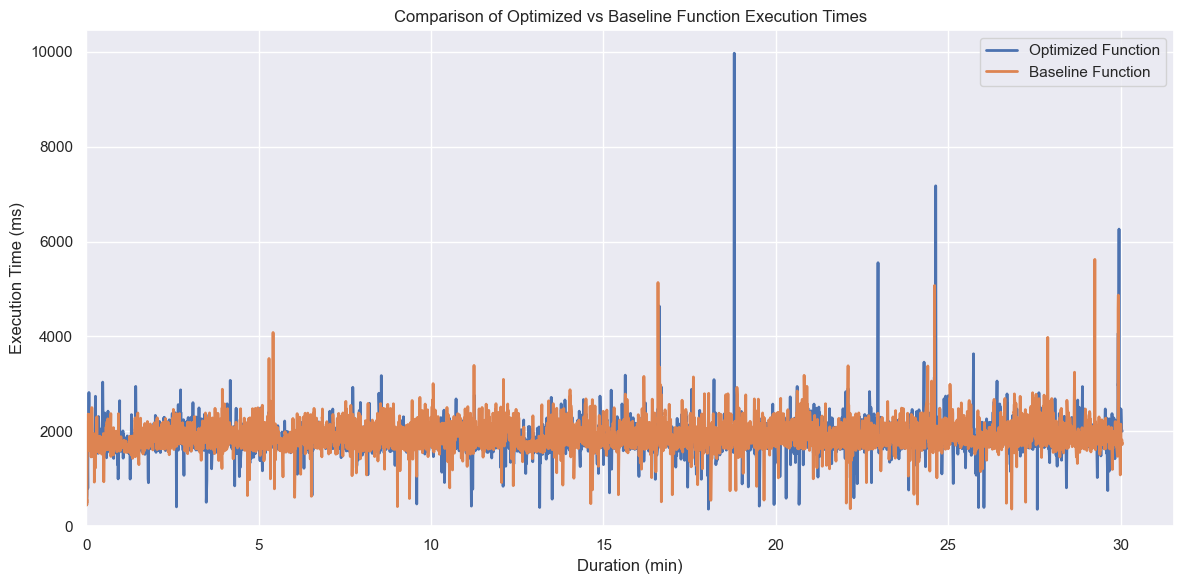

In [13]:
# EXECUTION TIME PLOT

sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot for optimized and baseline function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='execution_time', color=palette[0], label='Optimized Function', lw=2)
sns.lineplot(data=df_baseline, x='duration_minutes', y='execution_time', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(curr_exec_folder_path, "execution-times.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 

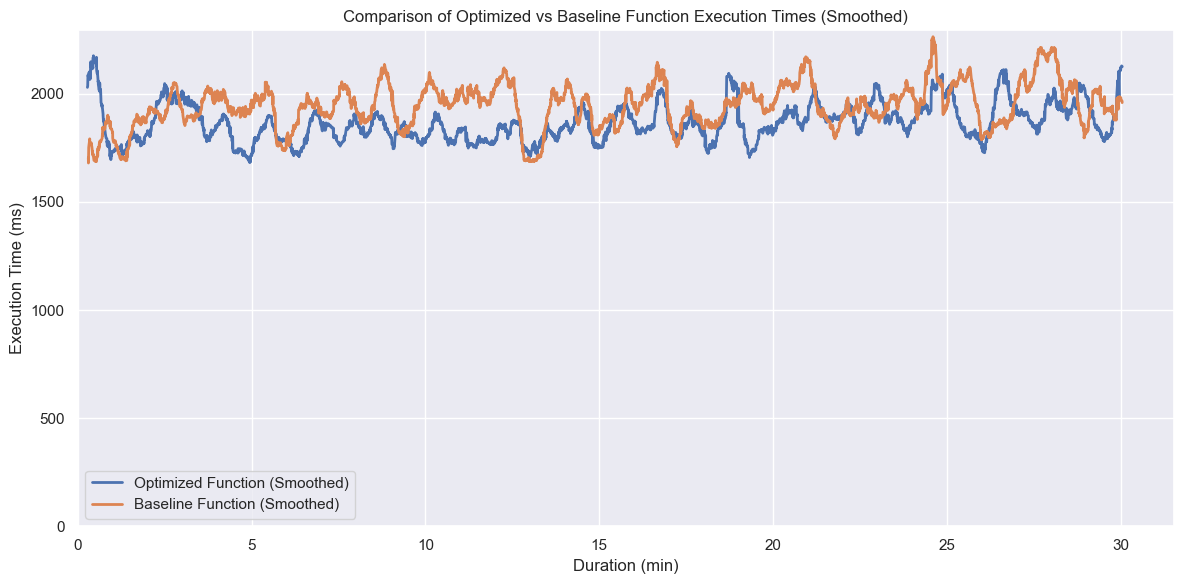

In [14]:
# EXECUTION TIME ROLLING AVG

sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='smoothed_execution_time', color=palette[0], label='Optimized Function (Smoothed)', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='duration_minutes', y='smoothed_execution_time', color=palette[1], label='Baseline Function (Smoothed)', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function Execution Times (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(curr_exec_folder_path, "execution-times-rolling-avg.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 

---

##### LR Duration

In [15]:
# Filter out zeros from crashed instances
df_optimized = df_optimized[df_optimized['lr_duration'] != 0]

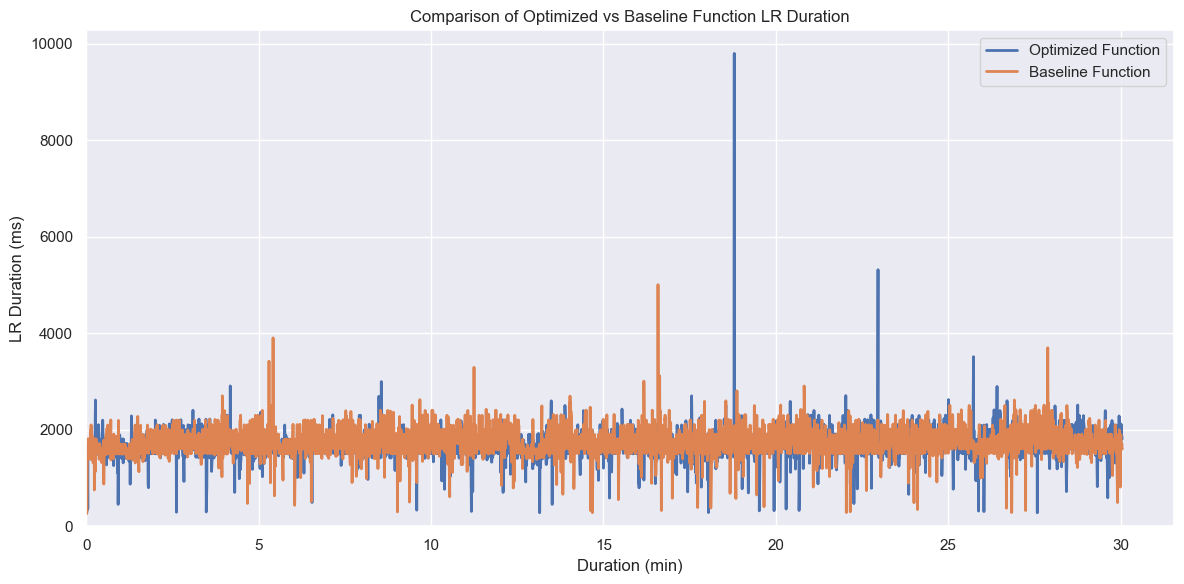

In [16]:
# LR DURATION PLOT
sns.set_theme(style="darkgrid")  # Options: darkgrid, whitegrid, dark, white, ticks
palette = sns.color_palette("deep")  # Options: "Set1", "Set2", "Set3", "coolwarm", "viridis", etc.

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='lr_duration', color=palette[0], label='Optimized Function', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='duration_minutes', y='lr_duration', color=palette[1], label='Baseline Function', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('LR Duration (ms)')
plt.title('Comparison of Optimized vs Baseline Function LR Duration')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(curr_exec_folder_path, "lr-duration.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 
plt.show() 

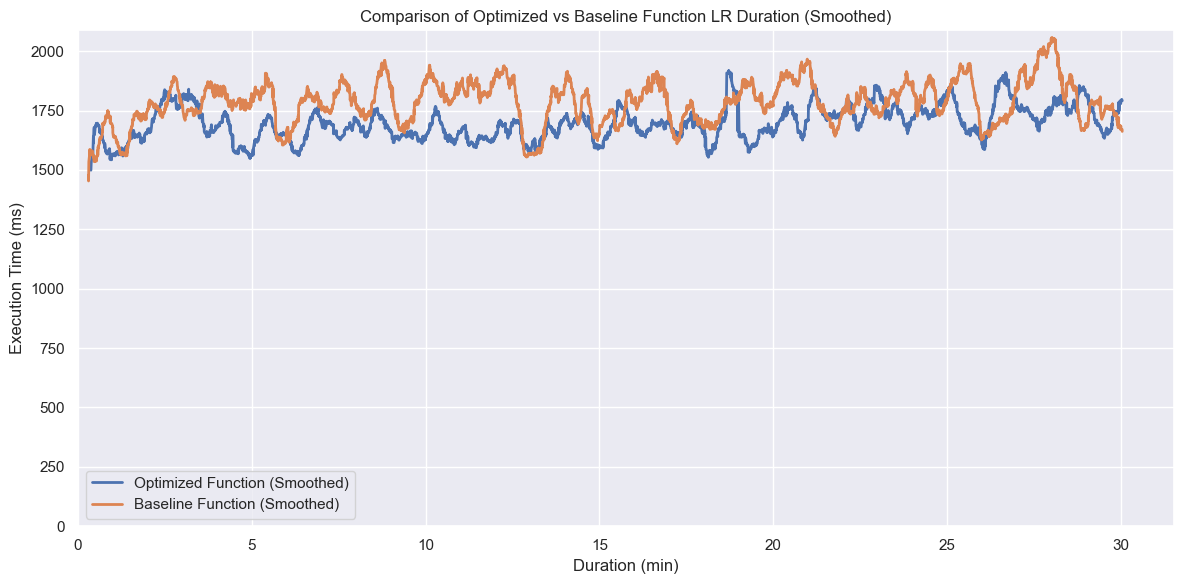

In [17]:
# LR DURATION ROLLING AVG

sns.set_theme(style="darkgrid")
palette = sns.color_palette("deep")

# Create the plot
plt.figure(figsize=(12, 6))

# Plot optimized function execution time
sns.lineplot(data=df_optimized, x='duration_minutes', y='smoothed_lr_duration', color=palette[0], label='Optimized Function (Smoothed)', lw=2)

# Plot baseline function execution time
sns.lineplot(data=df_baseline, x='duration_minutes', y='smoothed_lr_duration', color=palette[1], label='Baseline Function (Smoothed)', lw=2)

# Add labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Execution Time (ms)')
plt.title('Comparison of Optimized vs Baseline Function LR Duration (Smoothed)')

# Set x-axis and y-axis to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add a legend
plt.legend()

# Show plot
# Shrink layout
plt.tight_layout()

# SAVE PLOT
plot_filename = os.path.join(curr_exec_folder_path, "lr-duration-rolling-avg.pdf")
plt.savefig(plot_filename)
# SHOW PLOT
plt.show() 

---